In [1]:
from pathlib import Path
from model.network import Network

import cv2 as cv
import numpy as np

import torch
import os
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torchvision.utils import make_grid


class Args(object):
    def __init__(self):
        self.name = "exp_11"
        self.resolution = 256
        self.load_checkpoint = ""
        self.train = False
        self.dataset_path = Path("./dataset/")
        self.results_dir = Path("./output")
        self.pretrained_models_path = Path("./pretrained")
        self.train_data_size = 36000
        self.batch_size = 6
        self.reals = False
        self.test_real_attr = True
        self.train_real_attr = False
        self.weights_dir = self.results_dir.joinpath(self.name+"/weights")
        self.feature_embedding = False


args = Args()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

id_model_path = str(args.pretrained_models_path.joinpath(
    "20180402-114759-vggface2.pt"))
stylegan_G_path = str(args.pretrained_models_path.joinpath(
    "stylegan2-ffhq-256x256.pkl"))
landmarks_model_path = str(
    args.pretrained_models_path.joinpath('3DDFA/phase1_wpdc_vdc.pth.tar'))

network = Network(args=args, id_model_path=id_model_path, base_generator_path=stylegan_G_path,
                  landmarks_detector_path=landmarks_model_path, device=DEVICE)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


AttributeError: 'Args' object has no attribute 'parameter_embedding'

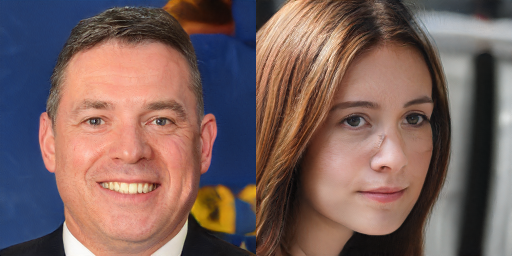

In [2]:
id_img_path = "gen_dataset/image/4000/3000.png"
id_img_seed = int(os.path.splitext(os.path.basename(id_img_path))[0])

attr_img_path = "gen_dataset/image/1000/964.png"

id_image = cv.imread(str(args.dataset_path.joinpath(id_img_path)))
attr_image = cv.imread(str(args.dataset_path.joinpath(attr_img_path)))

id_image = torch.from_numpy(id_image.transpose(
    (2, 0, 1))).float().to(DEVICE).flip(-3)
id_image.sub_(127.5).div_(128)
attr_image = torch.from_numpy(attr_image.transpose(
    (2, 0, 1))).float().to(DEVICE).flip(-3)
attr_image.sub_(127.5).div_(128)

show_image = torch.concat((id_image, attr_image), -1)
TF.to_pil_image(((show_image+1)/2))

In [6]:
with torch.no_grad():
    z = torch.randn((1000, 512)).to(DEVICE).clamp(-1, 1)
    # z = torch.from_numpy(np.random.RandomState(id_img_seed).randn(1, 512)).to(DEVICE)
    ws = network.generator.stylegan_generator.mapping(z, 0)
    ctrlv = torch.zeros((1000, 6048)).to(DEVICE)

    gen_id_image = network.generator.stylegan_generator.synthesis(ws, ctrlv)

    id_embedding = network.generator.id_encoder(gen_id_image)
    attr_embedding = network.generator.attr_encoder(
        torch.broadcast_to(attr_image, [200, *attr_image.shape]))

    # feature_input = torch.concat([id_embedding, attr_embedding], -1)
    feature_input = attr_embedding

    if args.feature_embedding:
        pose_sp_embedding = network.generator.reference_pose_encoder(
            feature_input)
        pose_control_vector = network.generator.reference_pose_decoder(
            pose_sp_embedding)
        expression_sp_embedding = network.generator.reference_expression_encoder(
            feature_input)
        expression_control_vector = network.generator.reference_expression_decoder(
            expression_sp_embedding)
        base_control_vector = 0
    else:
        base_control_vector = network.generator.reference_network(
            feature_input)
        pose_control_vector = expression_control_vector = 0

    control_vector = base_control_vector + \
        pose_control_vector + expression_control_vector

    gen_image = network.generator.stylegan_generator.synthesis(
        ws, control_vector)

TF.to_pil_image(make_grid(
    [((gen_id_image[0] + 1) / 2).clamp(0, 1), ((gen_image[0] + 1) / 2).clamp(0, 1)]))

RuntimeError: x is too large

In [4]:
train_img = ((gen_image + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
test_img = ((gen_id_image + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)

train_img = TF.resize(train_img, (299, 299)).cpu()
test_img = TF.resize(test_img, (299, 299)).cpu()

In [ ]:
from metrics.frechet_inception_distance import FIDScore

fid_score = FIDScore()

fid_score.calculate_fid(train_img, test_img)

In [5]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance()
fid.update(test_img, real=True)
fid.update(train_img, real=False)
fid.compute()

tensor(68.5260)

In [ ]:
def evaluation(network, id_image_path, attr_image_path_list, feature_embedding=False):

    id_image = cv.imread(str(args.dataset_path.joinpath(id_image_path)))
    id_image_seed = int(os.path.splitext(os.path.basename(id_image_path))[0])

    id_image = torch.from_numpy(id_image.transpose(
        (2, 0, 1))).float().to(DEVICE).flip(-3)
    id_image.sub_(127.5).div_(128)
    id_image = id_image.expand(len(attr_image_path_list), *id_image.shape)

    attr_image_list = []
    for attr_image_path in attr_image_path_list:

        attr_image = cv.imread(
            str(args.dataset_path.joinpath(attr_image_path)))
        attr_image = torch.from_numpy(attr_image.transpose(
            (2, 0, 1))).float().to(DEVICE).flip(-3)
        attr_image.sub_(127.5).div_(128)

        attr_image_list.append(attr_image[None, ...])

    attr_image = torch.concat(attr_image_list, 0)

    with torch.no_grad():
        # z = torch.randn((6,512)).to(DEVICE).clamp(-1, 1)
        zs = torch.from_numpy(np.random.RandomState(id_image_seed).randn(
            1, 512)).to(DEVICE).expand(len(attr_image_path_list), 512)
        ws = network.generator.stylegan_generator.mapping(zs, 0)
        # ctrlv = torch.zeros((1, 6048)).to(DEVICE)

        # gen_id_image = network.generator.stylegan_generator.synthesis(ws, ctrlv)

        id_embedding = network.generator.id_encoder(id_image)
        attr_embedding = network.generator.attr_encoder(attr_image)

        feature_input = torch.concat([id_embedding, attr_embedding], -1)

        if feature_embedding:
            pose_sp_embedding = network.generator.reference_pose_encoder(
                feature_input)
            pose_control_vector = network.generator.reference_pose_decoder(
                pose_sp_embedding)
            expression_sp_embedding = network.generator.reference_expression_encoder(
                feature_input)
            expression_control_vector = network.generator.reference_expression_decoder(
                expression_sp_embedding)
            base_control_vector = 0
        else:
            base_control_vector = network.generator.reference_network(
                feature_input)
            pose_control_vector = expression_control_vector = 0

        control_vector = base_control_vector + \
            pose_control_vector + expression_control_vector

        gen_image = network.generator.stylegan_generator.synthesis(
            ws, control_vector)

        out_image = torch.concat((attr_image, gen_image, id_image), -1)

    return gen_image, out_image, control_vector

In [ ]:
id_image_path = "image/4000/3000.png"
# id_image_path = "image/1000/877.png"
attr_image_path_list = ["image/1000/964.png", "image/1000/865.png",
                        "image/1000/877.png", "image/1000/14.png", "image/1000/26.png"]
gen_image, out_image, control_vector = evaluation(
    network, id_img_path, attr_image_path_list, args.feature_embedding)

In [ ]:
TF.to_pil_image(((out_image[0]+1)/2).clamp(0, 1))

In [ ]:
torch.topk(control_vector[0].abs(), 10).values, torch.topk(
    control_vector[0].abs(), 10).indices

In [ ]:
torch.topk(control_vector[1].abs(), 10).values, torch.topk(
    control_vector[1].abs(), 10).indices

In [ ]:
torch.topk(control_vector[2].abs(), 10).values, torch.topk(
    control_vector[2].abs(), 10).indices

In [ ]:
torch.topk(control_vector[3].abs(), 10).values, torch.topk(
    control_vector[3].abs(), 10).indices

In [ ]:
torch.topk(control_vector[4].abs(), 10).values, torch.topk(
    control_vector[4].abs(), 10).indices

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

channels = list(range(4928))
values = control_vector[0].tolist()

ax.bar(channels, values)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

channels = list(range(4928))
values = control_vector[1].squeeze().cpu().numpy()

ax.bar(channels, values)

plt.show()

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048)

# real_image = cv.imread("./dataset/ffhq256_dataset/00000/00037.png")
# real_image = torch.from_numpy(real_image.transpose((2, 0, 1)))[None, ...]
# real_image = real_image.flip(-3)
# real_image = TF.resize(real_image, (299, 299))

real_image = ((gen_id_image + 1) / 2 * 255).clamp(0, 255).to(torch.uint8).cpu()
fake_image = TF.resize(real_image, (299, 299))
fake_image = ((gen_image + 1) / 2 * 255).clamp(0, 255).to(torch.uint8).cpu()
fake_image = TF.resize(fake_image, (299, 299))

fid.update(real_image, real=True)
fid.update(fake_image, real=False)
fid.compute()

In [ ]:
torch.sqrt(torch.nn.functional.mse_loss(gen_id_image, gen_image)).item()

In [ ]:
from torchmetrics.functional import peak_signal_noise_ratio as psnr_metric

psnr_metric(id_image, gen_image, data_range=1.0).item()